In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import random

In [2]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

import matplotlib as mpl
import matplotlib.patches as patches

In [3]:
!pip uninstall pandas
!pip install pandas==1.3.3
import pandas as pd



^C


In [4]:
!pip install scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Step 1: Load datasets
cathode_data = pd.read_pickle("SR1S2OAnalysis_Cathode_SR3.pkl")
gate_data = pd.read_pickle("SR1S2OAnalysis_Gate_SR3.pkl")
signal_data = pd.read_pickle("SR1S2OAnalysis_Signal_SR3.pkl")

In [6]:
# Step 2: Label datasets
cathode_data['label'] = 0  # Cathode
gate_data['label'] = 1     # Gate
signal_data['label'] = 2   # Signal

In [7]:
# Step 3: Combine datasets
combined_data = pd.concat([cathode_data, gate_data, signal_data], ignore_index=True)

# Step 4: Inspect and clean data
# Identify non-numeric columns
non_numeric_cols = combined_data.select_dtypes(include=['object']).columns

# Encode non-numeric columns
encoder = LabelEncoder()
for col in non_numeric_cols:
    combined_data[col] = encoder.fit_transform(combined_data[col])

# Check for and handle invalid values (e.g., 'DD')
# Convert problematic strings to NaN
combined_data.replace({'DD': None}, inplace=True)

# Fill or drop missing values
combined_data.dropna(inplace=True)  # Alternatively, use .fillna()

In [8]:

# Step 5: Prepare features and labels
XAFT = combined_data [['scatterS2AFT1',
       'scatterS2AFT5', 'scatterS2AFT10', 'scatterS2AFT25', 'scatterS2AFT50',
       'scatterS2AFT75', 'scatterS2AFT90', 'scatterS2AFT95', 'scatterS2AFT99']]  # Features
y = combined_data['label']                # Labels




In [9]:
# Step 6: Split data
X_train, X_test, y_train, y_test = train_test_split(XAFT, y, test_size=0.2, random_state=42)



In [10]:
# Step 7: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61     14902
           1       0.74      0.47      0.57      1250
           2       0.91      0.91      0.91     67878

    accuracy                           0.85     84030
   macro avg       0.75      0.66      0.70     84030
weighted avg       0.85      0.85      0.85     84030

Confusion Matrix:
[[ 9062     1  5839]
 [   17   582   651]
 [ 5614   201 62063]]


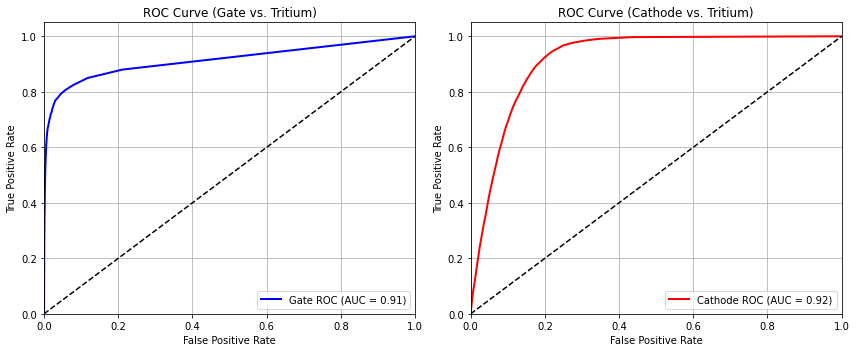

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get probability scores for each class
y_probT = rf_model.predict_proba(X_test)

# ROC for Gate (label 1) vs Tritium (label 2)
y_true_gate = (y_test == 1).astype(int)  # Binary target: 1 for Gate, 0 otherwise
y_prob_gate = y_probT[:, 1]  # Probability for Gate (class 1)
fpr_gate, tpr_gate, thresholds_gate = roc_curve(y_true_gate, y_prob_gate)
auc_gate = auc(fpr_gate, tpr_gate)

# ROC for Cathode (label 0) vs Tritium (label 2)
y_true_cathode = (y_test == 0).astype(int)  # Binary target: 1 for Cathode, 0 otherwise
y_prob_cathode = y_probT[:, 0]  # Probability for Cathode (class 0)
fpr_cathode, tpr_cathode, thresholds_cathode = roc_curve(y_true_cathode, y_prob_cathode)
auc_cathode = auc(fpr_cathode, tpr_cathode)

# Plot both ROC curves
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Gate vs. Tritium
ax[0].plot(fpr_gate, tpr_gate, color='blue', lw=2, label=f'Gate ROC (AUC = {auc_gate:.2f})')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve (Gate vs. Tritium)')
ax[0].legend(loc='lower right')
ax[0].grid()

# Plot Cathode vs. Tritium
ax[1].plot(fpr_cathode, tpr_cathode, color='red', lw=2, label=f'Cathode ROC (AUC = {auc_cathode:.2f})')
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve (Cathode vs. Tritium)')
ax[1].legend(loc='lower right')
ax[1].grid()

plt.tight_layout()
plt.show()


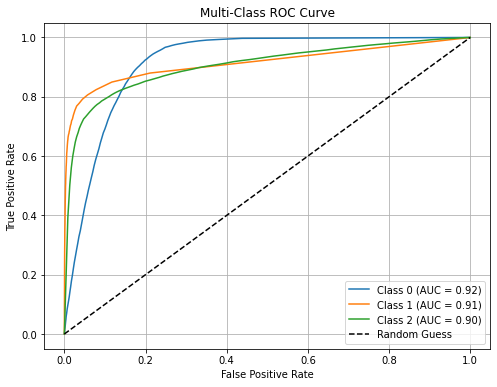

In [12]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assume `y_test` and `y_pred_proba` are defined
# y_test: true labels
# y_pred_proba: probabilities predicted by the model

# Step 1: Binarize the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)  # One-hot encoding of y_test

# Step 2: Get predicted probabilities for each class
y_pred_proba = rf_model.predict_proba(X_test)

# Step 3: Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Loop through each class
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [13]:
# To see all column names
print(combined_data.columns)


Index(['CX_HSX', 'CX_MUONVETO', 'CX_ETV', 'CX_S1RATE', 'CX_SUSTPHRATE',
       'CX_S2LB', 'CX_S2UB', 'CX_FV', 'CX_FCRES', 'CX_PROMINENTS2',
       'CX_NARROWS2', 'CX_S2EARLYPEAK', 'CX_XYQUAL', 'CX_S2TBA', 'CX_BUFF',
       'CX_BURST', 'CX_EXCESSAREA', 'triggerType', 'CX_S1TBA',
       'scatterS2pArea', 'scatterS2X', 'scatterS2Y', 'scatterDrift',
       'scatterS1pArea', 'CX_CATH', 'CX_GATE', 'scatterS2AFT1',
       'scatterS2AFT5', 'scatterS2AFT10', 'scatterS2AFT25', 'scatterS2AFT50',
       'scatterS2AFT75', 'scatterS2AFT90', 'scatterS2AFT95', 'scatterS2AFT99',
       'scatterS2fwhm', 'scatterS2rms', 'peakAmp', 'peakTime', 'scatterS2TBA',
       'scatterS2XYChi2', 'scatterS1TBA', 'badCount', 'badSum', 'badAhead',
       'scatterS2pStartTime', 'secondMaxS2pArea', 'secondMaxS2pAmp',
       'secondMaxS2pStartTime', 'secondMaxS2AFT5', 'secondMaxS2AFT10',
       'secondMaxS2AFT90', 'secondMaxS2AFT95', 'badSumBaseline', 'Volume',
       'scatterS2R2', 'scatterWidth', 'scatterS2Rise', 'CX_S2

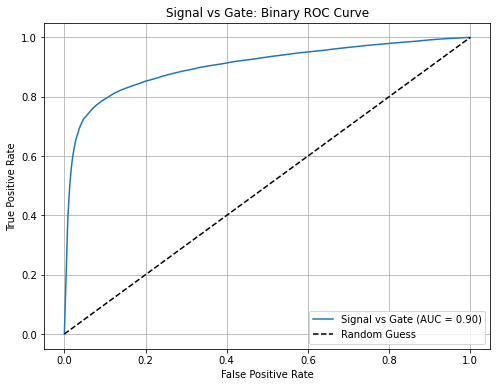

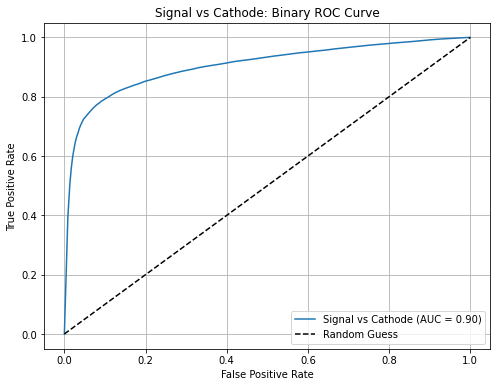

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Assume `y_test` and `y_pred_proba` are defined
# y_test: true labels
# y_pred_proba: probabilities predicted by the model

# Step 1: Binarize the labels for Signal vs Gate and Signal vs Cathode
lb = LabelBinarizer()

# For Signal vs Gate, map Signal -> 1, Gate -> 0
y_test_signal_gate = (y_test == 2).astype(int)  # Signal -> 1, others -> 0
y_pred_proba_signal_gate = y_pred_proba[:, 2]  # Get the probability for Signal class (2)

# For Signal vs Cathode, map Signal -> 1, Cathode -> 0
y_test_signal_cathode = (y_test == 2).astype(int)  # Signal -> 1, others -> 0
y_pred_proba_signal_cathode = y_pred_proba[:, 2]  # Get the probability for Signal class (2)

# Step 2: Compute ROC curve and AUC for Signal vs Gate
fpr_signal_gate, tpr_signal_gate, _ = roc_curve(y_test_signal_gate, y_pred_proba_signal_gate)
roc_auc_signal_gate = auc(fpr_signal_gate, tpr_signal_gate)

# Step 3: Compute ROC curve and AUC for Signal vs Cathode
fpr_signal_cathode, tpr_signal_cathode, _ = roc_curve(y_test_signal_cathode, y_pred_proba_signal_cathode)
roc_auc_signal_cathode = auc(fpr_signal_cathode, tpr_signal_cathode)

# Step 4: Plot Binary ROC curve for Signal vs Gate
plt.figure(figsize=(8, 6))
plt.plot(fpr_signal_gate, tpr_signal_gate, label=f'Signal vs Gate (AUC = {roc_auc_signal_gate:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Random Guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal vs Gate: Binary ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 5: Plot Binary ROC curve for Signal vs Cathode
plt.figure(figsize=(8, 6))
plt.plot(fpr_signal_cathode, tpr_signal_cathode, label=f'Signal vs Cathode (AUC = {roc_auc_signal_cathode:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Random Guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal vs Cathode: Binary ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [15]:
XTBA = combined_data [['scatterS2TBA','scatterS1TBA']]  # Features
y = combined_data['label']                # Labels
X_trainT, X_testT, y_trainT, y_testT = train_test_split(XTBA, y, test_size=0.2, random_state=42)

In [16]:
# Train a new RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters
rf_model.fit(X_trainT, y_trainT)  # Train on new feature set


RandomForestClassifier(random_state=42)

In [17]:

# Step 8: Evaluate the model
y_predT = rf_model.predict(X_testT)
print("Classification Report:")
print(classification_report(y_testT, y_predT))

print("Confusion Matrix:")
print(confusion_matrix(y_testT, y_predT))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.40      0.43     14902
           1       0.08      0.01      0.02      1250
           2       0.86      0.90      0.88     67878

    accuracy                           0.80     84030
   macro avg       0.47      0.44      0.44     84030
weighted avg       0.78      0.80      0.79     84030

Confusion Matrix:
[[ 5932    23  8947]
 [   69    13  1168]
 [ 6642   131 61105]]


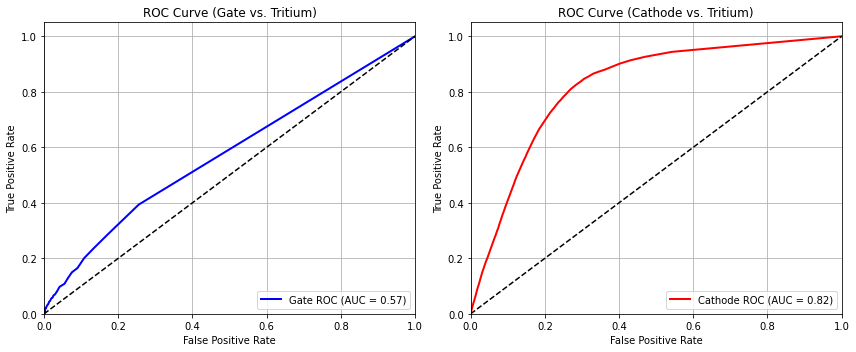

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get probability scores for each class
y_probT = rf_model.predict_proba(X_testT)

# ROC for Gate (label 1) vs Tritium
y_true_gate = (y_testT == 1).astype(int)  # Convert to binary: 1 if gate, 0 otherwise
y_prob_gate = y_probT[:, 1]  # Probability for gate
fpr_gate, tpr_gate, _ = roc_curve(y_true_gate, y_prob_gate)
auc_gate = auc(fpr_gate, tpr_gate)

# ROC for Cathode (label 0) vs Tritium
y_true_cathode = (y_testT == 0).astype(int)  # Convert to binary: 1 if cathode, 0 otherwise
y_prob_cathode = y_probT[:, 0]  # Probability for cathode
fpr_cathode, tpr_cathode, _ = roc_curve(y_true_cathode, y_prob_cathode)
auc_cathode = auc(fpr_cathode, tpr_cathode)

# Plot both ROC curves
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Gate vs. Tritium
ax[0].plot(fpr_gate, tpr_gate, color='blue', lw=2, label=f'Gate ROC (AUC = {auc_gate:.2f})')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve (Gate vs. Tritium)')
ax[0].legend(loc='lower right')
ax[0].grid()

# Plot Cathode vs. Tritium
ax[1].plot(fpr_cathode, tpr_cathode, color='red', lw=2, label=f'Cathode ROC (AUC = {auc_cathode:.2f})')
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve (Cathode vs. Tritium)')
ax[1].legend(loc='lower right')
ax[1].grid()

plt.tight_layout()
plt.show()


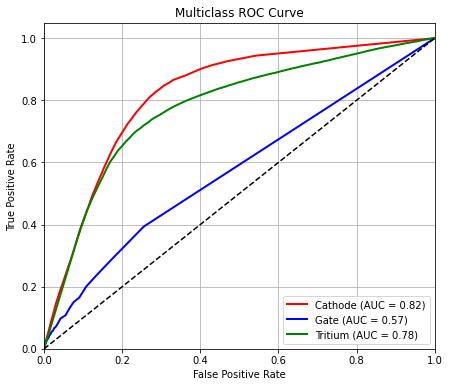

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels (one-hot encoding)
n_classes = 3
y_test_bin = label_binarize(y_testT, classes=[0, 1, 2])  # Convert y_testT to one-hot encoding
y_probT = rf_model.predict_proba(X_testT)  # Get probability scores

# Initialize dictionary to store ROC data
roc_data = {}

# Colors for each class
colors = ['red', 'blue', 'green']
class_labels = ['Cathode', 'Gate', 'Tritium']

# Plot ROC curves
plt.figure(figsize=(7, 6))

for i in range(n_classes):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probT[:, i])
    auc_score = auc(fpr, tpr)
    
    # Store for later analysis
    roc_data[class_labels[i]] = (fpr, tpr, auc_score)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_labels[i]} (AUC = {auc_score:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
